In [1]:
import pandas as pd

import numpy as np
import sys, os
import re

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib

In [2]:
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2.5
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

## Figure 3B: comparison between reporters with ARE and without ARE in 3'UTR

[Text(0, 0.0, '0%'), Text(0, 0.5, '50%'), Text(0, 1.0, '100%')]

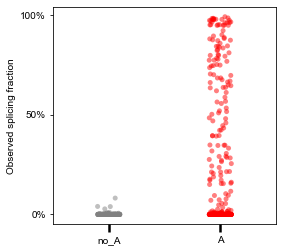

In [3]:
# import splicing quantification data
HELA = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')

HELA['A'] = HELA['RE'].apply(lambda g: 'A' if 'A' in g else 'no_A')
HELA['spliced_fraction'] = 1 - HELA['fraction']
toplot = HELA[HELA['best_category']=='full_length']

f, ax = plt.subplots(figsize = (4, 4))
sns.stripplot(
    data = toplot, 
    x = 'A', 
    y = 'spliced_fraction', 
    alpha = 0.5,
    palette = ['grey', 'red'],
    ax = ax
)
  
ax.set_xlabel('')
ax.set_ylabel('Observed splicing fraction')

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0%', '50%', '100%'])

#f.savefig('PLOTS/Fig_3B_ARE_vs_noARE.pdf', transparent = True)

## Figure 3C and Figure S3A: relationship between number of ARE copy and splicing efficieny at different acceptors

In [4]:
# import splicing data
hela = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')

# rename donor to GFP, alt-GFP, PRE, or others
def rename_donor(isoform):
    if isoform == 'full_length':
        return np.nan, np.nan
    elif 'GTACAA_132' in isoform:
        return 'GFP', 132
    elif 'CGAGCT_126' in isoform:
        return 'alt-GFP', 126
    elif 'CGACTT_171' in isoform:
        return 'PRE', 171
    elif 'CGACTT_204' in isoform:
        return 'PRE', 204
    else:
        return 'others', float(isoform.split('_')[1])
    
hela['donor_name'], hela['donor_pos'] = zip(*hela['best_category'].apply(lambda g: rename_donor(g)))

# group all donor together
hela_donor = hela.groupby(['RE', 'donor_name'])['fraction'].sum().reset_index()

# count number of ARE module
hela_donor['Acount'] = hela_donor['RE'].apply(lambda g: g.count('A'))

# only consider isoforms with fraction more than 0%
hela_donor = hela_donor[hela_donor['fraction']>0.00]

# get acceptor names
def get_acceptor_loc(RE, isoform):
    
    if isoform == 'full_length':
        return np.nan, np.nan, np.nan
    else:
        spl = isoform.split('_')
        loc = float(spl[3])
        acc = 'other'
        module = 'other'
        
        if len(RE) == 4 and RE != 'Dna2':
            if 157 < loc < 190:
                module = 1
                acc = RE[0]
            elif 190 < loc < 223:
                module = 2
                acc = RE[1]
            elif 223 < loc < 256:
                module = 3
                acc = RE[2]
            elif 256 < loc < 290:
                module = 4
                acc = RE[3]
            elif 290 < loc < 334:
                module = 'spacer'
                acc = 'spacer'
            
        return acc, loc, module
    
        
hela['acceptor_name'], hela['acceptor_pos'], hela['acceptor_module'] = zip(*hela.apply(
    lambda g: get_acceptor_loc(g['RE'], g['best_category']), axis = 1)
                                                 )
# group all acceptors together
hela_acc = hela.groupby(['RE', 'acceptor_name'])['fraction'].sum().reset_index()

# count number of ARE module
hela_acc['Acount'] = hela_acc['RE'].apply(lambda g: g.count('A'))

# only consider isoforms with fraction more than 0%
hela_acc = hela_acc[hela_acc['fraction']>0.00]

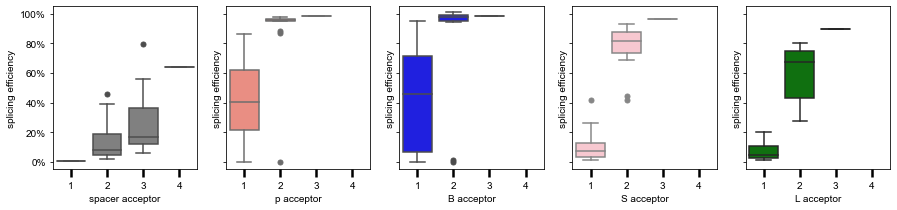

In [7]:
f, axs = plt.subplots(ncols = 5, figsize = (15, 3), sharey = True)

for ax, acc, color in zip(axs, ['spacer', 'p', 'B', 'S', 'L'], ['grey', 'salmon', 'blue', 'pink', 'green']):
    sns.boxplot(
        data = hela_acc[hela_acc['acceptor_name']==acc], 
        x = 'Acount', 
        y = 'fraction', 
        order = [1, 2, 3, 4],
        flierprops = {'marker': 'o'},
        color = color,
        ax = ax
    )

    ax.set_xlabel(f'{acc} acceptor')
    ax.set_ylabel('splicing efficiency')
    
    ax.set_ylim(-0.05, 1.05)
   
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


#f.savefig('PLOTS/Fig_3C_S3A_count_vs_spliced_fraction_by_acceptor.pdf', transparent = True)

## Figure 3E: exonic ARE represses downstream splice donor

In [6]:
# select reports with PRE module in pos 2, with and without ARE module in pos 1
patterns = {
    '[BLSp]pA[BLSp]': 'noAup',
    '[BLSp]p[BLSp]A': 'noAup',
    '[BLSp]pAA': 'noAup',
    'ApA[BLSp]': 'Aup',
    'Ap[BLSp]A': 'Aup',
    'ApAA': 'Aup',
}


def match_pattern(RE):
    for pattern, name in patterns.items():
        if re.search(pattern, RE):
            return name
        
    return '****'

hela_donor['pattern'] = hela_donor['RE'].apply(lambda g: match_pattern(g))

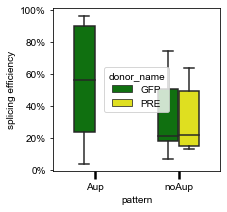

In [7]:
f, ax = plt.subplots(figsize = (3, 3))

sns.boxplot(
    data = hela_donor, 
    x = 'pattern', 
    y = 'fraction', 
    order = ['Aup', 'noAup'],
    hue = 'donor_name', 
    hue_order = ['GFP', 'PRE'],
    dodge = True,
    palette = ['green', 'yellow'],
    width = 0.5,
    flierprops = {'marker': 'o'},
    ax = ax
)

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_ylabel('splicing efficiency')

f.savefig('PLOTS/Fig_3E_ARE_upstream_downstream.pdf')

## Figure 3F: ARE functions as a polypyrimidine tract

In [12]:
# group all acceptors together
hela_lastARE = hela.groupby(['RE', 'acceptor_module'])['fraction'].sum().reset_index()
hela_lastARE = hela_lastARE[hela_lastARE['fraction']>0.00]

# get the 3' most ARE
def get_3most_ARE(RE):
    if RE[3] == 'A':
        return 4
    elif RE[2] == 'A':
        return 3
    elif RE[1] == 'A':
        return 2
    elif RE[1] == 'A':
        return 1
    else:
        return 0
    
hela_lastARE['lastARE'] = hela_lastARE['RE'].apply(lambda g: get_3most_ARE(g))

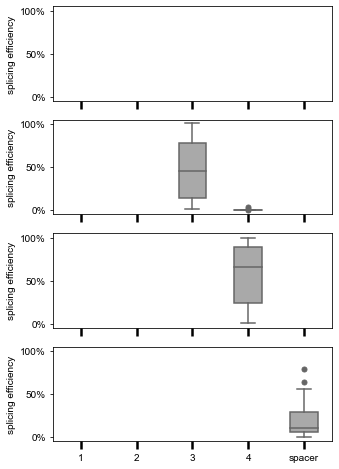

In [14]:
f, axs = plt.subplots(nrows = 4, figsize = (5, 8), sharex = True)

for lastARE, ax in zip([1, 2, 3, 4], axs):
    sns.boxplot(
        data = hela_lastARE[hela_lastARE['lastARE']==lastARE], 
        x = 'acceptor_module', 
        y = 'fraction', 
        order = [1, 2, 3, 4, 'spacer'],
        width = 0.5,
        color = 'darkgrey',
        flierprops = {'marker': 'o'},
        ax = ax
    )
    
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_yticks([0, 0.5, 1.0])
    ax.set_yticklabels(['0%', '50%', '100%'])
    ax.set_ylabel('splicing efficiency')
    
f.savefig('PLOTS/Fig_3F_last_ARE_boxplot.pdf', transparent = True)

## Figure 3G: exonic ARE represses upstream splice acceptor

In [8]:
# get reporters with ARE in pos 2, with and without ARE in pos 4
patterns = {
    '[BLSpA]A[BLSp][BLSp]': 'noARE4',
    '[BLSpA]A[BLSp]A': 'ARE4',
}

def match_pattern(RE):
    for pattern, name in patterns.items():
        if re.search(pattern, RE):
            return name
        
    return '****'

hela_acc['pattern'] = hela_acc['RE'].apply(lambda g: match_pattern(g))

# change acceptor name (L, P, S, and B) to RE but keep spacer
hela_acc['acceptor_name'] = hela_acc['acceptor_name'].apply(lambda g: 'RE' if g != 'spacer' else g)
hela_acc = hela_acc[hela_acc['fraction']>0.01] # exclude reporters less than 1% spliced

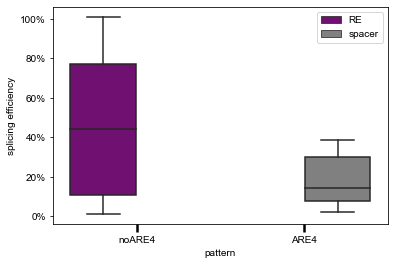

In [9]:
f, ax = plt.subplots()

sns.boxplot(
    data = hela_acc, 
    x = 'pattern', 
    order = ['noARE4', 'ARE4'],
    y = 'fraction', 
    hue = 'acceptor_name', 
    hue_order = ['RE', 'spacer'],
    palette = ['purple', 'grey'],
    ax = ax
)

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_ylabel('splicing efficiency')

ax.legend(bbox_to_anchor = (1, 1))

f.savefig('PLOTS/Fig_3H_RE_vs_spacer_acceptor.pdf', transparent = True)

## Figure S3C: comparison between continous and non-continous ARE tracks

In [18]:
# classify reporters as continuous or non-continuous
patterns = {
    'A[BLSp]A[BLSp]': 'noncont',
    '[BLSp]AA[BLSp]': 'cont',
    'AA[BLSp][BLSp]': 'cont',
}


def match_pattern(RE):
    for pattern, name in patterns.items():
        if re.search(pattern, RE):
            return name
        
    return '****'

HELA['pattern'] = HELA['RE'].map(lambda g: match_pattern(g))

/var/folders/ly/fgzs9d8s7txdbr22383tmh0c0000gr/T/ipykernel_6505/210895335.py:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


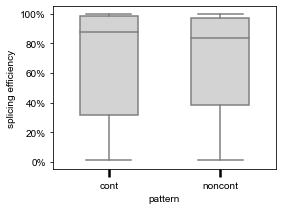

In [20]:
f, ax = plt.subplots(figsize = (4, 3))

sns.boxplot(
    data = HELA[HELA['spliced_fraction']>0.0], 
    x = 'pattern', 
    y = 'spliced_fraction', 
    order = ['cont', 'noncont'],
    flierprops = {"marker": "o"},
    color = 'lightgrey',
    ax = ax
)

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_ylabel('splicing efficiency')

adjust_box_widths(f, 0.65)

ax.set_ylim(-0.05, 1.05)

f.savefig('PLOTS/Fig_S3C_non_continuous_ARE_track.pdf', transparent = True)

## Figure S3E: intronic ARE enhances PRE donor

In [21]:
# Classify reporters as having 0-3 ARE dowstream of PRE module
patterns = {
    '[BLSp][BLSp]pA': '****',
    'p[BLSp][BLSp][BLSp]': 'p+0A',
    'ppA[BLSp]': 'p+1A',
    'pA[BLSp][BLSp]': 'p+1A', 
    'p[BLSp]A[BLSp]': 'p+1A',
    'p[BLSp][BLSp]A': 'p+1A', 
    'pAA[BLSp]': 'p+2A',
    'pA[BLSp]A': 'p+2A', 
    'p[BLSp]AA': 'p+2A',
    'pAAA': 'p+3A',
}


def match_pattern(RE):
    for pattern, name in patterns.items():
        if re.search(pattern, RE):
            return name
        
    return '****'

hela_donor['pattern'] = hela_donor['RE'].apply(lambda g: match_pattern(g))

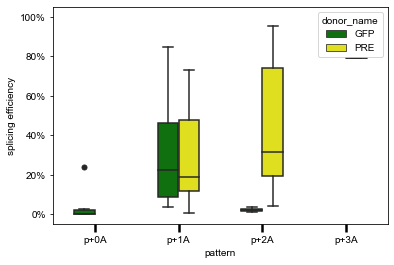

In [23]:
f, ax = plt.subplots()

sns.boxplot(
    data = hela_donor, 
    x = 'pattern', 
    y = 'fraction', 
    order = ['p+0A', 'p+1A', 'p+2A', 'p+3A'],
    hue = 'donor_name', 
    hue_order = ['GFP', 'PRE'],
    dodge = True,
    palette = ['green', 'yellow'],
    width = 0.5,
    flierprops = {'marker': 'o'},
    ax = ax
)

ax.set_ylim(-0.05, 1.05)

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_ylabel('splicing efficiency')

f.savefig('PLOTS/Fig_S3E_PRE_impact_on_donor.pdf')